# Imports

In [2]:
import os
os.chdir("/Users/evanrootness/DS_Projects/EtsyDSProject")
pwd = os.getcwd()
print(pwd)

/Users/evanrootness/DS_Projects/EtsyDSProject


In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import math
import scipy.optimize as opt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
import re

In [4]:
import_data = pd.read_csv(pwd + '/data/ArtAllPages.csv')
# import_data = pd.read_csv(pwd + '/data/art_map.csv')
raw_data = import_data.copy()

# Data Cleaning

In [5]:
data = raw_data.drop(['web-scraper-order', 'web-scraper-start-url', 'product_link-href', 'Pagination', 'product_link'], axis = 1)

In [6]:
print(data.shape)
data

(1111, 3)


,name,min_price,size_options
0,"Pastel Art, Mint Green Wall Art, Mint Green Ar...",Price:\n $6.00,[]
1,"San Francisco Print, Golden Gate Bridge Wall A...",Price:\n $18.00+,"[{""size_options"":""Select an option\n ..."
2,"Set 4 Coral Prints Mist Blue/Green, Nautical p...",Price:\n $82.00+,"[{""size_options"":""Select a size\n ..."
3,Whale nursery art. Whale Rider print,Price:\n $20.00+,"[{""size_options"":""Select a size\n ..."
4,Valentine's Day Copper Rose / Seventh Annivers...,Price:\n $160.00+,"[{""size_options"":""Select an option\n ..."
...,...,...,...
1106,"Yellow Leopard 20oz Tumbler Sublimation Wrap,G...",Price:\n $4.80,[]
1107,"Tropical Little Thing Mini Crab, Driftwood Wal...",Price:\n $150.00,[]
1108,"Fall Pumpkin Mug Sublimation, Watercolor Flora...",Price:\n $2.00,[]
1109,Pheasant Art Print Giclee Limited Edition,Price:\n $39.89,[]


In [7]:
data.describe()

,name,min_price,size_options
count,1111,1111,1111
unique,1041,508,412
top,"Yellow Leopard 20oz Tumbler Sublimation Wrap,G...",Price:\n $18.00+,[]
freq,5,32,547


In [8]:
data = data.astype(dtype='string')
data.dtypes

name            string[python]
min_price       string[python]
size_options    string[python]
dtype: object

In [9]:
price = []

for i in range(len(data['min_price'])):
    price.append(re.search('[^+]*', data['min_price'][i]).group(0))
    price[i] = re.search('[^\$]*$', price[i]).group(0).replace(',', '')

data['min_price'] = price
data['min_price'] = data['min_price'].astype(float)

## Convert Names to Categorical Data

In [10]:
sys.path.insert(1, '/Users/evanrootness/DS_Projects/EtsyDSProject/py_scripts/')
import scripts_explore

In [11]:
# one-hot encode categorical data from listing names (encode most popular keywords)
data = scripts_explore.one_hot_encode(data, ['Watercolor', 'Portrait', 'Pet', 'Print', 'Family', 'Paint', 'Painting', 'Nature', 'Custom', 'Abstract', 'House', 'Map'])
# data

*Considering parsing all names and doing a full count of all possible words to see which are most common rather than guessing.

In [12]:
# I don't want to include maps in my analysis so get rid of them
data = data.query('Map != 1')
data = data.drop(columns='Map')
data = data.reset_index(drop=True)

## Convert "size options" to price and size lists

In [13]:
# example of string that needs to be parsed into sizes and prices
data['size_options'][27]

'[]'

Types of patterns we need to match for sizes:
- "#x#" (inches assumed, but no units)
- "#x# inches"
- "# x # inches"
- "#x#in"
- "#x#cm"
- "#x# cm"
- '#\\" x #\\" inches'

In [14]:
pattern = r'(\d+)\\" x (\d+)\\"'
string = data['size_options'][27]
matches = re.findall(pattern, string)
# floats_only = [(float(match[0]), float(match[2])) for match in matches]
# floats_only
matches

[]

In [15]:
data

,name,min_price,size_options,Watercolor,Portrait,Pet,Print,Family,Paint,Painting,Nature,Custom,Abstract,House
0,"Pastel Art, Mint Green Wall Art, Mint Green Ar...",6.00,[],1,0,0,1,0,0,0,0,0,1,0
1,"San Francisco Print, Golden Gate Bridge Wall A...",18.00,"[{""size_options"":""Select an option\n ...",0,0,0,1,0,0,0,0,0,0,0
2,"Set 4 Coral Prints Mist Blue/Green, Nautical p...",82.00,"[{""size_options"":""Select a size\n ...",0,0,0,1,0,0,0,0,0,0,0
3,Whale nursery art. Whale Rider print,20.00,"[{""size_options"":""Select a size\n ...",0,0,0,0,0,0,0,0,0,0,0
4,Valentine's Day Copper Rose / Seventh Annivers...,160.00,"[{""size_options"":""Select an option\n ...",0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,"Yellow Leopard 20oz Tumbler Sublimation Wrap,G...",4.80,[],0,0,0,0,0,0,0,0,0,0,0
1049,"Tropical Little Thing Mini Crab, Driftwood Wal...",150.00,[],0,0,0,0,0,0,0,0,0,0,1
1050,"Fall Pumpkin Mug Sublimation, Watercolor Flora...",2.00,[],1,0,0,0,0,0,0,0,0,0,0
1051,Pheasant Art Print Giclee Limited Edition,39.89,[],0,0,0,1,0,0,0,0,0,0,0


In [16]:
# the regex patterns to match
prices_pattern = re.compile('\$(.+?)\)')

pattern_nothing = r'(\d+)x(\d+)'
pattern_nothing_dec = r'(\d+(\.\d+)?x\d+(\.\d+)?)'
pattern_space_nothing = r'(\d+) x (\d+)'

pattern_space_space_inches = r'(\d+) x (\d+)(?= in)'
pattern_space_inches = r'(\d+)?x(\d+)(?= in)'
pattern_inches = r'(\d+)x(\d+)(?=in)'
pattern_space_space_inches_dec = r'(\d+(\.\d+)?) x (\d+(\.\d+)?(?= in))'
pattern_space_inches_dec = r'(\d+(\.\d+)?x\d+(\.\d+)?(?= in))'
pattern_inches_dec = r'(\d+(\.\d+)?x\d+(\.\d+)?(?=in))'

pattern_space_space_cm = r'(\d+) x (\d+)(?= cm)'
pattern_space_cm = r'(\d+)?x(\d+)(?= cm)'
pattern_cm = r'(\d+)x(\d+)(?=cm)'
pattern_space_space_cm_dec = r'(\d+(\.\d+)?) x (\d+(\.\d+)?(?= cm))'
pattern_space_cm_dec = r'(\d+(\.\d+)?x\d+(\.\d+)?(?= cm))'
pattern_cm_dec = r'(\d+(\.\d+)?x\d+(\.\d+)?(?=cm))'

weird_pattern = r'(\d+)\\" x (\d+)\\"'

# initialize empty lists
prices = []
sizes = []
inches = []

In [17]:
#iterate through each listing to get a list of the size/price options
for text in data['size_options']:
    
    # find all possible matches in the input string
    nothing_matches = re.findall(pattern_nothing, text)
    nothing_matches_dec = re.findall(pattern_nothing_dec, text)
    sp_nothing_matches = re.findall(pattern_space_nothing, text)
    
    spsp_inches_matches = re.findall(pattern_space_space_inches, text)
    sp_inches_matches = re.findall(pattern_space_inches, text)
    inches_matches = re.findall(pattern_inches, text)
    spsp_inches_matches_dec = re.findall(pattern_space_space_inches_dec, text)
    sp_inches_matches_dec = re.findall(pattern_space_inches_dec, text)
    inches_matches_dec = re.findall(pattern_inches_dec, text)
    
    spsp_cm_matches = re.findall(pattern_space_space_cm, text)
    sp_cm_matches = re.findall(pattern_space_cm, text)
    cm_matches = re.findall(pattern_cm, text)
    spsp_cm_matches_dec = re.findall(pattern_space_space_cm_dec, text)
    sp_cm_matches_dec = re.findall(pattern_space_cm_dec, text)
    cm_matches_dec = re.findall(pattern_cm_dec, text)
    
    weird_matches = re.findall(weird_pattern, text)
    
    price_matches = re.findall(prices_pattern, text)
    
    # append current listing's list to temporary list    
    if (not not spsp_inches_matches):
        sizes.append(spsp_inches_matches)
        inches.append(1)
    elif (not not sp_inches_matches):
        sizes.append(sp_inches_matches)
        inches.append(1)
    elif (not not inches_matches):
        sizes.append(inches_matches)
        inches.append(1)
        
    elif (not not spsp_inches_matches_dec):
        sizes.append([(float(match[0]), float(match[2])) for match in spsp_inches_matches_dec])
        inches.append(1)
    elif (not not sp_inches_matches_dec):
        sizes.append([(float(match[0]), float(match[2])) for match in sp_inches_matches_dec])
        inches.append(1)
    elif (not not inches_matches_dec):
        sizes.append([(float(match[0]), float(match[2])) for match in inches_matches_dec])
        inches.append(1)
        
        
    elif (not not weird_matches):
        sizes.append(weird_matches)
        inches.append(1)
       
        
    elif (not not spsp_cm_matches):
        sizes.append(spsp_cm_matches) 
        inches.append(0)
    elif (not not sp_cm_matches):
        sizes.append(sp_cm_matches)
        inches.append(0)
    elif (not not cm_matches):
        sizes.append(cm_matches)
        inches.append(0)
        
    elif (not not spsp_cm_matches_dec):
        sizes.append([(float(match[0]), float(match[2])) for match in spsp_cm_matches_dec])
        inches.append(0)
    elif (not not sp_cm_matches_dec):
        sizes.append([(float(match[0]), float(match[2])) for match in sp_cm_matches_dec])
        inches.append(0)
    elif (not not cm_matches_dec):
        sizes.append([(float(match[0]), float(match[2])) for match in cm_matches_dec])
        inches.append(0)
    
    
    elif (not not nothing_matches):
        sizes.append(nothing_matches)
        inches.append(1)
    elif (not not nothing_matches_dec):
        sizes.append([(float(match[0]), float(match[2])) for match in nothing_matches_dec])
        inches.append(1)
    elif (not not sp_nothing_matches):
        sizes.append(sp_nothing_matches)
        inches.append(1)
        
    else:
        sizes.append(np.nan)
        inches.append(np.nan)
    
    if (not not price_matches):
        prices.append(price_matches)
    else:
        prices.append(np.nan)
    
# add new column on data with list of prices
data['prices'] = prices
data['sizes'] = sizes
data['inches'] = inches

# drop old column
# data.drop(data['size_options'])

In [18]:
print(data['sizes'].dropna().count())

342


In [19]:
data_sizes = data.dropna(subset=['sizes', 'prices'])
data_sizes = data_sizes.reset_index(drop=False)
# data_sizes

## Clean prices

In [20]:
data_sizes.loc[data_sizes['index'] == 1042]

,index,name,min_price,size_options,Watercolor,Portrait,Pet,Print,Family,Paint,Painting,Nature,Custom,Abstract,House,prices,sizes,inches
336,1042,Kangaroo Art Print - Rustic Australian Interio...,19.0,"[{""size_options"":""Select a size\n ...",0,0,0,1,0,0,0,0,0,0,0,"[19.00 - $22.00, 29.00 - $32.00, 39.00 - $42.0...","[(8, 10), (12, 16), (16, 20), (18, 24), (24, 3...",1.0


In [21]:
data_sizes.iloc[237]['size_options']

'[{"size_options":"Select a size\\n                \\n                \\n                        5x7\\" ($12.13)\\n                \\n                \\n                        A5 ($12.13)\\n                \\n                \\n                        8x10\\" ($24.25)\\n                \\n                \\n                        A4 ($24.25)\\n                \\n                \\n                        11x14\\" ($48.50)\\n                \\n                \\n                        A3 ($48.50)"}]'

In [22]:
data_sizes['prices'].iloc[0]

['18.00',
 '36.00',
 '56.00',
 '71.00',
 '102.00',
 '128.00',
 '138.00',
 '153.00',
 '163.00']

In [23]:
# get rid of commas and ranges in prices, and convert to floats
price_list = []
for i in range(len(data_sizes)):
    # get rid of ranged prices
    temp_prices = []
    for j in range(len(data_sizes['prices'].iloc[i])):
        if ('-' in data_sizes['prices'].iloc[i][j]):
            temp_prices.append(data_sizes['prices'].iloc[i][j].split()[0])
        else:
            temp_prices.append(data_sizes['prices'].iloc[i][j])
    price_list.append(temp_prices)
        
    # get rid of commas in prices
    for j in range(len(price_list[i])):
        if (',' in price_list[i][j]):
            price_list[i][j] = price_list[i][j].replace(',', '')
        
# convert to floats
price_list_float = []

for ilist in price_list:
    temp_list = []
    if type(ilist) is list:
        for string in ilist:
            temp_list.append(float(string))
    else:
        temp_list.append(float(ilist))
    price_list_float.append(temp_list)
    
# print(price_list_float)
data_sizes['prices'] = price_list_float

## Create new features

In [24]:
# convert cm to inches
cm_to_inch_conv = 2.54
sizes_list = []
for i in range(len(data_sizes)):
    # if the size is currently in cm
    if (data_sizes['inches'].iloc[i] == 0):
        temp_sizes = []
        for j in range(len(data_sizes['sizes'].iloc[i])):
            width_in = float(data_sizes['sizes'].iloc[i][j][0]) / cm_to_inch_conv
            height_in = float(data_sizes['sizes'].iloc[i][j][1]) / cm_to_inch_conv
            temp_sizes.append((width_in, height_in))
        sizes_list.append(temp_sizes)
            
    else:
        sizes_list.append(data_sizes['sizes'].iloc[i])
# sizes_list
data_sizes['sizes_in'] = sizes_list

In [25]:
data_sizes['prices']

0      [18.0, 36.0, 56.0, 71.0, 102.0, 128.0, 138.0, ...
1      [82.0, 128.0, 178.0, 336.0, 448.0, 564.0, 628....
2                                     [40.0, 30.0, 20.0]
3                          [33.23, 44.68, 91.66, 126.03]
4      [38.25, 52.7, 52.7, 57.8, 57.8, 68.85, 68.85, ...
                             ...                        
335       [13.6, 25.5, 42.5, 51.0, 76.5, 114.75, 148.75]
336           [19.0, 29.0, 39.0, 49.0, 59.0, 59.0, 69.0]
337           [49.5, 64.8, 79.2, 81.0, 49.5, 64.8, 81.0]
338                                  [48.0, 125.0, 22.0]
339                                   [14.0, 19.0, 24.0]
Name: prices, Length: 340, dtype: object

In [26]:
# create area lists
areas_list = []
for i in range(len(data_sizes)):
    
    temp_areas = []
    for j in range(len(data_sizes['sizes_in'].iloc[i])):
        width_in = float(data_sizes['sizes_in'].iloc[i][j][0])
        height_in = float(data_sizes['sizes_in'].iloc[i][j][1])
        temp_areas.append(width_in * height_in)
    areas_list.append(temp_areas)
    
data_sizes['areas'] = areas_list
    

In [27]:
data_sizes['areas']

0      [35.0, 80.0, 154.0, 192.0, 320.0, 480.0, 600.0...
1      [35.0, 80.0, 154.0, 320.0, 432.0, 864.0, 320.0...
2                                    [154.0, 80.0, 35.0]
3      [223.2004464008928, 542.50108500217, 1085.0021...
4      [35.0, 80.0, 88.0, 154.0, 176.0, 192.0, 216.0,...
                             ...                        
335      [35.0, 80.0, 154.0, 192.0, 320.0, 480.0, 720.0]
336    [80.0, 192.0, 320.0, 432.0, 768.0, 864.0, 1200.0]
337                           [35.0, 80.0, 154.0, 192.0]
338                                       [216.0, 600.0]
339                                  [35.0, 80.0, 154.0]
Name: areas, Length: 340, dtype: object

In [28]:
data_sizes['size_options'][2]

'[{"size_options":"Select a size\\n                \\n                \\n                        11x14 inches ($40.00)\\n                \\n                \\n                        8x10 inches ($30.00)\\n                \\n                \\n                        5x7 inches ($20.00)"}]'

In [29]:
data_sizes['areas'][2]

[154.0, 80.0, 35.0]

In [30]:
# calculate price per square inch (ppsi)
ppsi_list = []
for i in range(len(data_sizes)):
    
    temp_ppsis = []
    
    if (len(data_sizes['prices'][i]) == len(data_sizes['areas'][i])):
        
        for j in range(len(data_sizes['prices'].iloc[i])):
            temp_ppsis.append(data_sizes['prices'].iloc[i][j] / data_sizes['areas'].iloc[i][j])
            
        ppsi_list.append(temp_ppsis)
        
    else:
        ppsi_list.append(np.nan)
    
data_sizes['ppsi'] = ppsi_list

In [31]:
data_sizes['ppsi'][2]

[0.2597402597402597, 0.375, 0.5714285714285714]

In [32]:
data_sizes['sizes'].iloc[1]

[('5', '7'),
 ('8', '10'),
 ('14', '11'),
 ('16', '20'),
 ('18', '24'),
 ('24', '36'),
 ('16', '20'),
 ('16', '20'),
 ('11', '14'),
 ('18', '24'),
 ('28', '40')]

# Data Exploration

In [35]:
data_cheap = data.query('min_price < 100')
data_expensive = data.query('min_price > 100')

## Histograms of individual categories

(array([2., 0., 0., 0., 2., 1., 1., 1., 1., 1.]),
 array([ 6.75 , 11.575, 16.4  , 21.225, 26.05 , 30.875, 35.7  , 40.525,
        45.35 , 50.175, 55.   ]),
 <BarContainer object of 10 artists>)

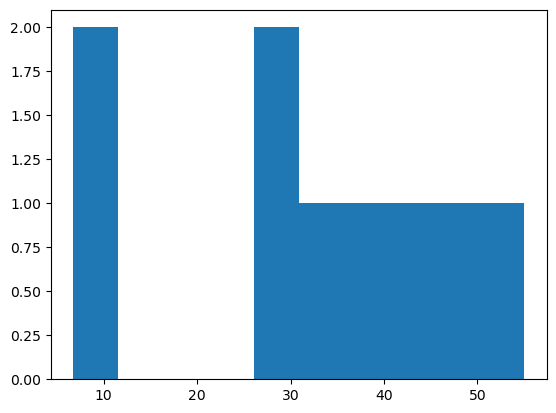

In [38]:
plt.hist(data.query('Pet == 1')['min_price'])

(array([34., 20., 19.,  5.,  3.,  0.,  0.,  1.,  0.,  2.]),
 array([ 2.   , 11.777, 21.554, 31.331, 41.108, 50.885, 60.662, 70.439,
        80.216, 89.993, 99.77 ]),
 <BarContainer object of 10 artists>)

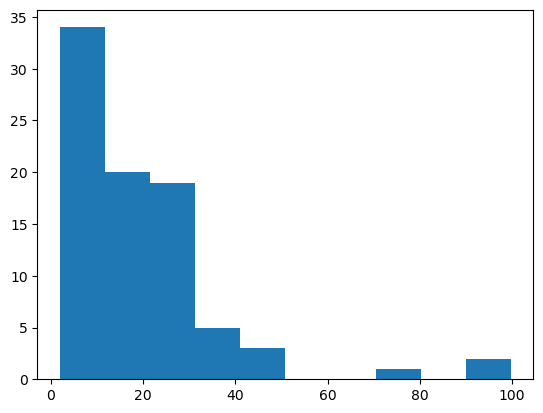

In [39]:
plt.hist(data_cheap.query('Watercolor == 1')['min_price'])

(array([19., 11., 11.,  5.,  5.,  2.,  2.,  1.,  0.,  3.]),
 array([ 3.54 , 13.163, 22.786, 32.409, 42.032, 51.655, 61.278, 70.901,
        80.524, 90.147, 99.77 ]),
 <BarContainer object of 10 artists>)

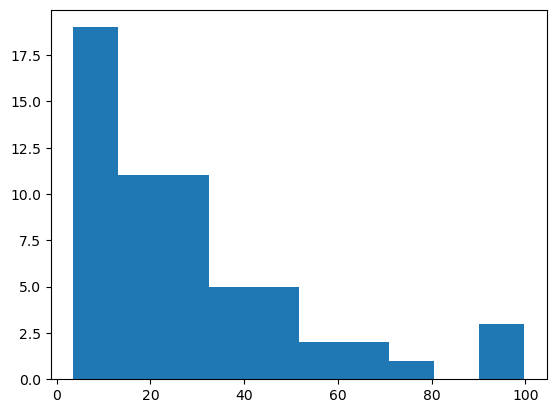

In [40]:
plt.hist(data_cheap.query('Paint == 1')['min_price'])

## Cheap listing exploration (< $100)

In [41]:
category_list = ['Paint', 'Watercolor', 'Print', 'Portrait', 'Custom', 'House', 'Abstract']
for caty in category_list:
    print(caty, len(data_cheap.query('{0} == 1'.format(caty))))
print('Total number of listings above $100:', len(data_cheap))

Paint 59
Watercolor 84
Print 480
Portrait 25
Custom 37
House 24
Abstract 69
Total number of listings above $100: 939


In [42]:
# caty = 'Pet'
# np.mean(data_cheap.query('{0} == 1'.format(caty))['min_price'])

### Visualization

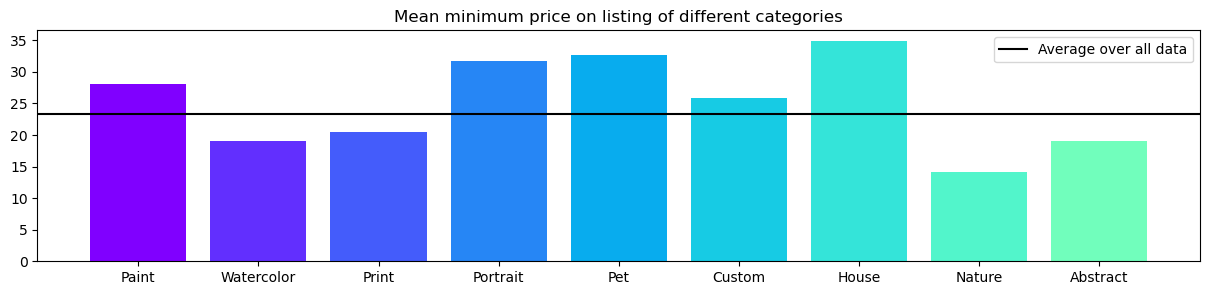

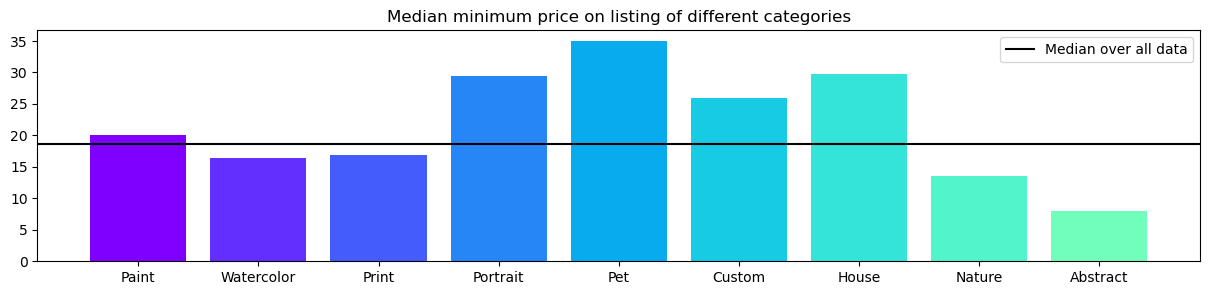

In [43]:
category_list = ['Paint', 'Watercolor', 'Print', 'Portrait', 'Pet', 'Custom', 'House', 'Nature', 'Abstract']
scripts_explore.bar_plot_categories_mean(data_cheap, category_list)
scripts_explore.bar_plot_categories_median(data_cheap, category_list)

Key takeaways:
- Highest averages include: paintings, portraits, art of pets, and art of houses
- Highest medians include: portraits, art of pets, custom art, and art of houses
- Lowest averages and medians include: watercolors, prints, natures, and abstracts
- Average (minimum*) price of an art listing is roughly $23 and median is #18

## Expensive listings exploration (> $100)

In [44]:
category_list = ['Paint', 'Watercolor', 'Print', 'Portrait', 'Custom', 'House', 'Abstract']
for caty in category_list:
    print(caty, len(data_expensive.query('{0} == 1'.format(caty))))
print('Total number of listings above $100:', len(data_expensive))

Paint 17
Watercolor 5
Print 15
Portrait 6
Custom 8
House 2
Abstract 12
Total number of listings above $100: 111


There are very few listings above $100 (111), so we need to be careful about any observations we make regarding that portion of the data.

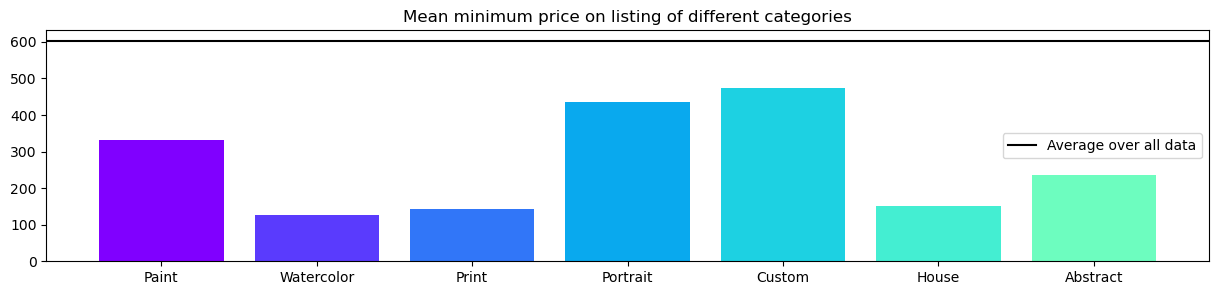

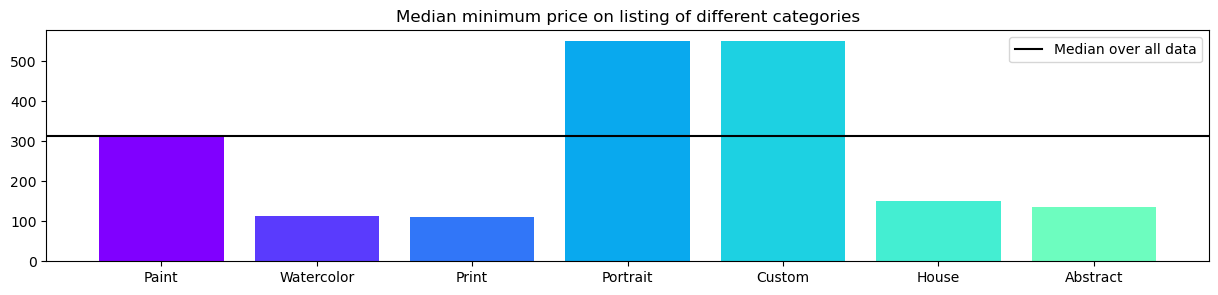

In [45]:
category_list = ['Paint', 'Watercolor', 'Print', 'Portrait', 'Custom', 'House', 'Abstract']
scripts_explore.bar_plot_categories_mean(data_expensive, category_list)
scripts_explore.bar_plot_categories_median(data_expensive, category_list)

Key takeaways:
- Highest averages include: paintings, portraits, and custom art
- Highest medians include: paintings, portraits, and custom art
- Lowest averages and medians include: watercolors, prints, house are and abstracts
- Average (minimum*) price of an expensive art listing is roughly $600 and median is $320

After noticing the average is much higher than any of our categorys' averages, I decide to check out what the other very expensive listings are

In [46]:
indx = data_expensive.iloc[:, 3:14].where(data_expensive.iloc[:, 3:14] == 0).dropna().index.to_list()
data_expensive.loc[indx, :]['name']

4       Valentine's Day Copper Rose / Seventh Annivers...
66      Fruit oil painting still life, fruit wall art,...
90                  Needle Felted Red Fox - Made to Order
127               1911 Bay Tree Royal Imperial Easter Egg
135     Traditional Lithuanian Woodcut Saint Izidorius...
                              ...                        
996                      Mr Toad - limited edition bronze
1008    PBJ pink & gold (Artist's touch) - NOAH VERRIE...
1017                                  Spring Collection 2
1018                                  Spring Collection 4
1040    Tortoise hatchling on the move. Open edition b...
Name: name, Length: 71, dtype: string

# EDA with listing name

## Determine most common words in listing names

In [47]:
data_names = data[['name', 'min_price', 'prices', 'sizes', 'inches']]
sys.path.insert(1, '/Users/evanrootness/DS_Projects/EtsyDSProject/py_scripts/')
import scripts_data_transformation

In [48]:
unique_word_list, word_counter = scripts_data_transformation.df_to_list_and_dict(data['name'])

Total number of words among all listing names: 16470
Count of unique words among all listing names: 3415


In [49]:
words_ordered = scripts_data_transformation.order_words(word_counter, unique_word_list)
print('The top 10 most common words in listing names:', words_ordered[0, :10])

The top 10 most common words in listing names: ['Art' 'Print' 'Wall' '-' 'art' 'Decor' 'print' '|' 'Gift' 'Printable']


<BarContainer object of 100 artists>

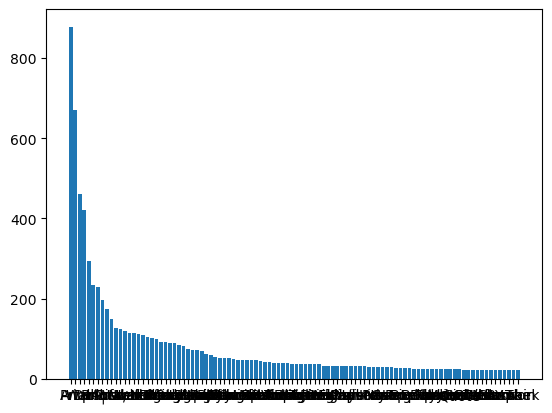

In [50]:
plt.bar(words_ordered[0, :100], words_ordered[1, :100].astype(int))

## One-hot encode and write to csv

Get rid of Python key words that mess with 'query' command (i.e. '-', '|', '/', 'and', and 'for')

In [71]:
words_ordered_clean = scripts_data_transformation.remove_ordered_words(words_ordered, ['-', '|', '/', 'and', 'for', 'in', 'or', '&', 'with'])

length_ordered = 20
# one-hot encode categorical data from listing names (encode most popular keywords)
data_encoded = scripts_explore.one_hot_encode(data_names, list(words_ordered_clean[0, :length_ordered]))
data_encoded_csv = data_encoded.to_csv('cleaned.csv', index=False)  

In [74]:
import os
import csv

# Define the path to the folder where your notebook is located
current_folder = os.getcwd()  # Get current working directory

# Define the path to the folder where you want to create the new CSV file
target_folder = current_folder + '/data/'

# Check if the target folder exists, if not, give error
if not os.path.exists(target_folder):
    raise Exception('target folder', target_folder, 'does not exist')
    # os.makedirs(target_folder)

# Define the filename for the new CSV file
csv_filename = 'cleaned_data.csv'

# Combine the target folder path with the filename to get the full path
csv_path = os.path.join(target_folder, csv_filename)

data_encoded.to_csv(csv_path, index=False)

print(f"CSV file '{csv_filename}' has been created in '{target_folder}'.")

CSV file 'cleaned_data.csv' has been created in '/Users/evanrootness/DS_Projects/EtsyDSProject/data/'.


## Determine which words signify the most difference in prices

In [52]:
test = scripts_explore.significance(data_encoded, words_ordered_clean[0][:length_ordered])
differences = np.array([test[0, :], test[1, :].astype(float) - test[2, :].astype(float)])

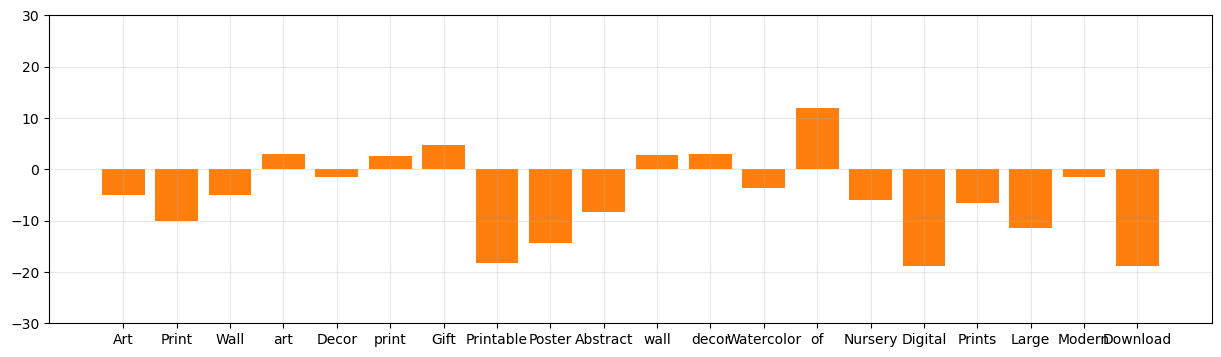

In [53]:
plt.figure(figsize=(15, 4))
for i in range(len(differences)):
    if float(differences[1, i]) > 0:
        plt.bar(differences[0, :], height=differences[1, :].astype(float))
    else:
        plt.bar(differences[0, :], height=differences[1, :].astype(float))
plt.ylim(-30, 30)
plt.grid(alpha=0.3)

In [54]:
print(len(differences[0, :]), len(differences))
pivoted = np.transpose(differences)
print(len(pivoted[0, :]), len(pivoted))

20 2
2 20


In [55]:
for diff in pivoted[:, :]:
    if abs(float(diff[1])) > 15:
        print(diff[0], diff[1])

Printable -18.28
Digital -18.78
Download -18.78


I think I want to try first using the top 20 most common words. I can then evaulate and see how effective these parameters (whether or not a listing name contains a word) are at guessing true listing prices.

Other tests to run:
* What changes if I take out all listings without any of the top __ common words in their name?
* What changes if more/less common words are used?